![logo](../imgs/MLU_Logo.png)

---

# Train/Deploy/Test a Multiclass Model 

This exercise is about executing all the steps of the Machine Learning development pipeline, using some features SageMaker offers. We'll use here a public dataset called iris. Iris is a toy dataset and this is a very simple example. The idea here is to focus on the SageMaker features and not on a complex scenario. Let's see how SageMaker can accelerate your work and avoid wasting your time with tasks that aren't related to your business. 

SageMaker library 2.0+ is required!

## Import the Dataset
Let's  start by importing the dataset and visualize it!

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import datasets
sns.set(color_codes=True)

iris = datasets.load_iris()

X=iris.data
y=iris.target

dataset = np.insert(iris.data, 0, iris.target,axis=1)

df = pd.DataFrame(data=dataset, columns=['iris_id'] + iris.feature_names)
df['species'] = df['iris_id'].map(lambda x: 'setosa' if x == 0 else 'versicolor' if x == 1 else 'virginica')

df.head()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,0.0,5.1,3.5,1.4,0.2,setosa
1,0.0,4.9,3.0,1.4,0.2,setosa
2,0.0,4.7,3.2,1.3,0.2,setosa
3,0.0,4.6,3.1,1.5,0.2,setosa
4,0.0,5.0,3.6,1.4,0.2,setosa


In [2]:
df.describe()

,iris_id,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,1.000000,5.843333,3.057333,3.758000,1.199333
std,0.819232,0.828066,0.435866,1.765298,0.762238
min,0.000000,4.300000,2.000000,1.000000,0.100000
25%,0.000000,5.100000,2.800000,1.600000,0.300000
50%,1.000000,5.800000,3.000000,4.350000,1.300000
75%,2.000000,6.400000,3.300000,5.100000,1.800000
max,2.000000,7.900000,4.400000,6.900000,2.500000


### Checking the Class Distribution

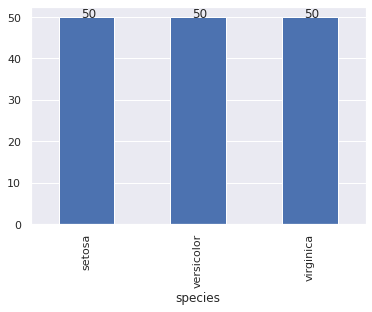

In [3]:
ax = df.groupby(df['species'])['species'].count().plot(kind='bar')
x_offset = -0.05
y_offset = 0
for p in ax.patches:
    b = p.get_bbox()
    val = "{}".format(int(b.y1 + b.y0))
    ax.annotate(val, ((b.x0 + b.x1)/2 + x_offset, b.y1 + y_offset))

### Correlation Matrix

<AxesSubplot:>

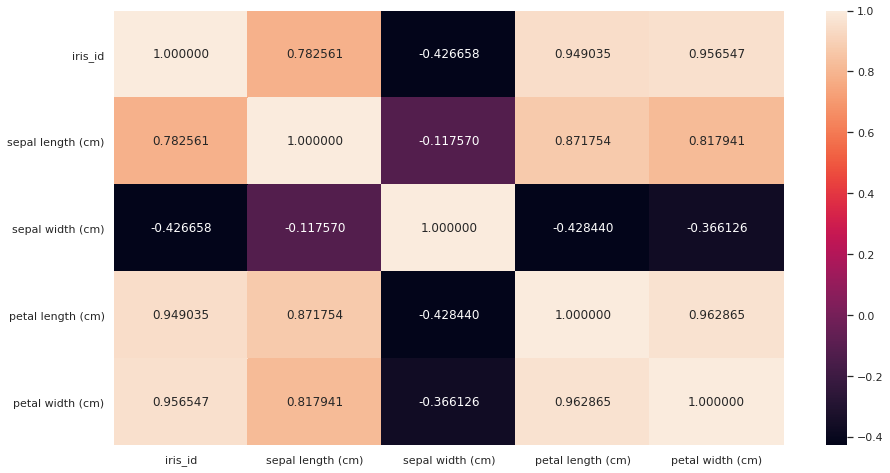

In [4]:
corr = df.corr()

f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corr, annot=True, fmt="f",
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,
            ax=ax)

### Pairplots & Histograms

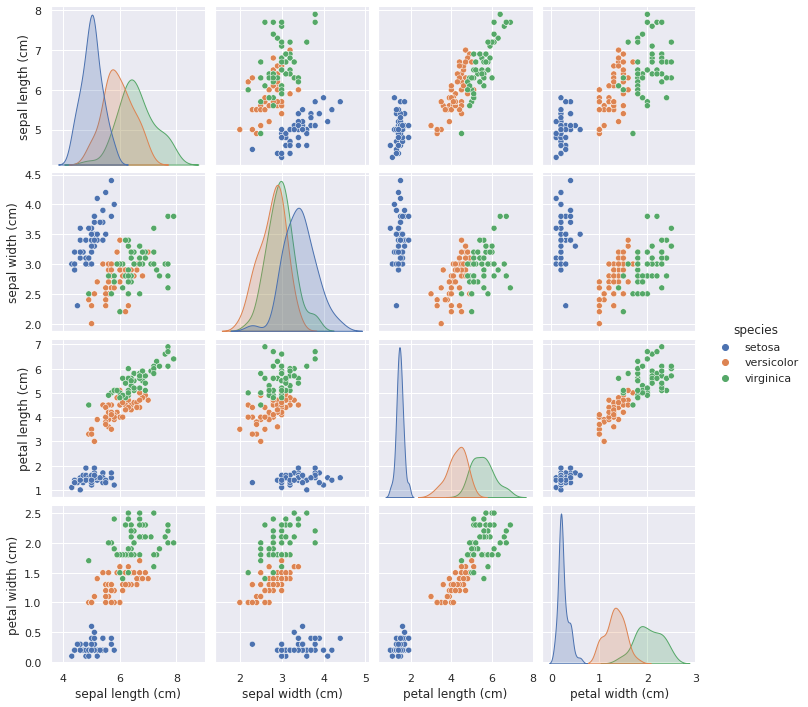

In [5]:
sns.pairplot(df.drop(['iris_id'], axis=1), hue='species', height=2.5, diag_kind="kde")

### Now with linear regression

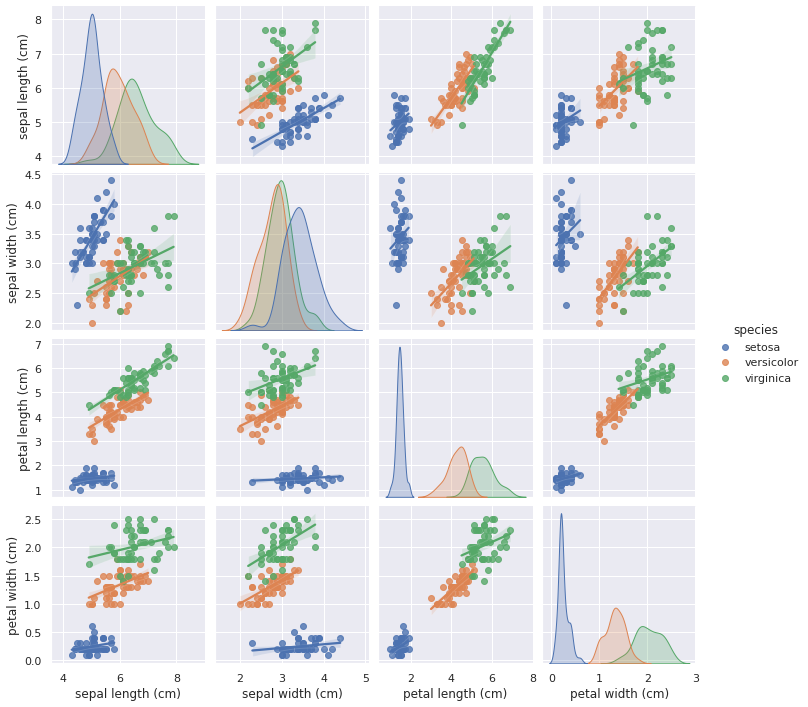

In [6]:
sns.pairplot(df.drop(['iris_id'], axis=1), kind="reg", hue='species', height=2.5,diag_kind="kde")

### Fit a plot a kernel density estimate.
We can see in this dimension an overlaping between **versicolor** and **virginica**. This is a better representation of what we identified above.

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using silverman for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/distributions.py:1676: UserWarning: `shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0.05`, but please update your code.
  warnings.warn(msg, UserWarning)
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/seaborn/_decor

Text(0.5, 0, 'species')

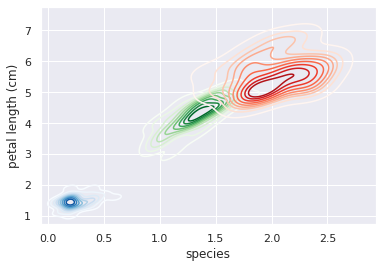

In [7]:
tmp_df = df[(df.iris_id==0.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap="Blues", shade=False, shade_lowest=False)

tmp_df = df[(df.iris_id==1.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap="Greens", shade=False, shade_lowest=False)

tmp_df = df[(df.iris_id==2.0)]
sns.kdeplot(tmp_df['petal width (cm)'], tmp_df['petal length (cm)'], bw='silverman', cmap="Reds", shade=False, shade_lowest=False)

plt.xlabel('species')

Ok. Petal length and petal width have the highest linear correlation with our label. Also, sepal width seems to be useless, considering the linear correlation with our label.

Since versicolor and virginica cannot be split linearly, we need a more versatile algorithm to create a better classifier. In this case, we'll use XGBoost, a tree ensemble that can give us a good model for predicting the flower.

## Train an XGBoost Model

First, let's split the dataset into training and test.

In [8]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
yX_train = np.column_stack((y_train, X_train))
yX_test = np.column_stack((y_test, X_test))
np.savetxt("iris_train.csv", yX_train, delimiter=",", fmt='%0.3f')
np.savetxt("iris_test.csv", yX_test, delimiter=",", fmt='%0.3f')

We will initialize the builtin algorithm XGBoost.

In [9]:
import sagemaker
import boto3

from sagemaker import get_execution_role
from sklearn.model_selection import train_test_split

role = get_execution_role()

prefix='mlops/iris'
# Retrieve the default bucket
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
assert(sagemaker.__version__ >= "2.0")

Now we upload the dataset and train the model.

In [10]:
# Upload the dataset to an S3 bucket
input_train = sagemaker_session.upload_data(path='iris_train.csv', key_prefix='%s/data' % prefix)
input_test = sagemaker_session.upload_data(path='iris_test.csv', key_prefix='%s/data' % prefix)

In [11]:
train_data = sagemaker.inputs.TrainingInput(s3_data=input_train,content_type="csv")
test_data = sagemaker.inputs.TrainingInput(s3_data=input_test,content_type="csv")

In [12]:
# get the URI for new container
container_uri = sagemaker.image_uris.retrieve('xgboost', boto3.Session().region_name, version='1.0-1')

# Create the estimator
xgb = sagemaker.estimator.Estimator(container_uri,
                                    role, 
                                    instance_count=1, 
                                    instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket, prefix),
                                    sagemaker_session=sagemaker_session)
# Set the hyperparameters
xgb.set_hyperparameters(eta=0.1,
                        max_depth=10,
                        gamma=4,
                        num_class=len(np.unique(y)),
                        alpha=10,
                        min_child_weight=6,
                        silent=0,
                        objective='multi:softmax',
                        num_round=30)

It is the time for training!

(Note the training will take roughly **~5 minutes**.)

In [13]:
%%time
# takes around 3min 11s
xgb.fit({'train': train_data, 'validation': test_data, })

2021-04-07 23:44:26 Starting - Starting the training job...
2021-04-07 23:44:48 Starting - Launching requested ML instancesProfilerReport-1617839066: InProgress
......
2021-04-07 23:45:49 Starting - Preparing the instances for training......
2021-04-07 23:46:49 Downloading - Downloading input data...
2021-04-07 23:47:09 Training - Downloading the training image...
2021-04-07 23:47:52 Uploading - Uploading generated training model
2021-04-07 23:47:52 Completed - Training job completed
INFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter objective value multi:softmax to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input i

## Deploy to the Endpoint

Let's deploy the model and create an endpoint for it. The following action will:
 * get the assets from the job we just ran and then create an input in the Models Catalog
 * create a endpoint configuration (a metadata for our final endpoint)
 * create an endpoint, which is our model wrapped in a format of a WebService
 
After that we'll be able to call our deployed endpoint for doing predictions.

(Note: The follow deployment cell may run around **~10 minutes**. You can find your endpoint at [Sagemaker Endpoints](https://console.aws.amazon.com/sagemaker/home?region=us-east-1#/endpoints).)


In [14]:
%%time
# Enable log capturing in the endpoint
data_capture_configuration = sagemaker.model_monitor.data_capture_config.DataCaptureConfig(
    enable_capture=True, 
    sampling_percentage=100, 
    destination_s3_uri='s3://{}/{}/monitoring'.format(bucket, prefix), 
    sagemaker_session=sagemaker_session
)
xgb_predictor = xgb.deploy(
    initial_instance_count=1, 
    instance_type= 'ml.m4.xlarge', ## 'ml.t3.medium'
    data_capture_config=data_capture_configuration
)

-----------------!CPU times: user 264 ms, sys: 18.1 ms, total: 282 ms
Wall time: 8min 32s


## Setup the Monitor

Alright, now that we have deployed the endpoint, with data capturing enabled, it's time to setup the monitor.
Let's start by configuring our predictor

In [15]:
from sagemaker.serializers import CSVSerializer
from sklearn.metrics import f1_score
csv_serializer = CSVSerializer()

endpoint_name = xgb_predictor.endpoint_name
model_name = boto3.client('sagemaker').describe_endpoint_config(
    EndpointConfigName=endpoint_name
)['ProductionVariants'][0]['ModelName']
!echo $model_name > model_name.txt
!echo $endpoint_name > endpoint_name.txt
xgb_predictor.serializer = csv_serializer

## Test the Endpoint

Now, let's do a basic test with the deployed endpoint. We'll use a helper object called **predict**. This object is always returned from a **Deploy** call. 

The predictor is just for testing purposes and we'll **NOT** use it inside our real application.

In [16]:
predictions_test = [ float(xgb_predictor.predict(x).decode('utf-8')) for x in X_test] 
score = f1_score(y_test,predictions_test,labels=[0.0,1.0,2.0],average='micro')

print('F1 Score(micro): %.1f' % (score * 100.0))

F1 Score(micro): 90.0


## Test the API

Then, let's  test the API for our trained model. Using `boto3` for getting a sagemaker runtime client and then we'll call invoke_endpoint

In [17]:
from sagemaker.serializers import CSVSerializer
csv_serializer = CSVSerializer()

sm = boto3.client('sagemaker-runtime')
resp = sm.invoke_endpoint(
    EndpointName=endpoint_name,
    ContentType='text/csv',
    Body=csv_serializer.serialize(X_test[0])
)
prediction = float(resp['Body'].read().decode('utf-8'))
print('Predicted class: %.1f for [%s]' % (prediction, csv_serializer.serialize(X_test[0])) )

Predicted class: 1.0 for [6.3,2.8,5.1,1.5]


## Cleaning up (Attention! Read the message before deleting the Endpoint)
Only run the next cell if you will **NOT** continue running the next part of the lab. Please feel free to optimize your model using other algorithms or AutoML ([AutoGluon](https://auto.gluon.ai/stable/index.html)). Have Fun!

In [18]:
# xgb_predictor.delete_endpoint()


![logo](../imgs/MLU_Logo.png)
